In [1]:
import warnings
import six
import numpy as np
import pandas as pd
from ppca import PPCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, Birch, FeatureAgglomeration, SpectralClustering, SpectralCoclustering, SpectralBiclustering, DBSCAN, AffinityPropagation, MeanShift
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA, FastICA, IncrementalPCA, KernelPCA, FactorAnalysis, TruncatedSVD, SparsePCA, MiniBatchSparsePCA, DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.manifold import TSNE, MDS, SpectralEmbedding, LocallyLinearEmbedding, Isomap
from umap import UMAP
import os
import tensorflow as tf
import tensorflow_hub as hub
from configparser import ConfigParser
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from align import hyper, srm, procrustes

global HYPERTOOLS_NOTEBOOK_MODE; HYPERTOOLS_NOTEBOOK_MODE = False

In [2]:
#debugging stuff
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
defaults = ConfigParser()
defaults.read('defaults.ini');

In [4]:
def hypertools_notebook_mode(toggle=None):
    global HYPERTOOLS_NOTEBOOK_MODE
    
    if toggle:
        print('Enabling inline hypertools plots')
        init_notebook_mode(connected=True)
        HYPERTOOLS_NOTEBOOK_MODE = True
    else:
        print('Disabling interactive hypertools plots')
        init_notebook_mode(connected=False)
        HYPERTOOLS_NOTEBOOK_MODE = False
    return None

In [5]:
hypertools_notebook_mode(True)

Enabling inline hypertools plots


In [6]:
reduce_models = ['DictionaryLearning', 'FactorAnalysis', 'FastICA', 'IncrementalPCA', 'KernelPCA', 'LatentDirichletAllocation', 'MiniBatchDictionaryLearning',
 'MiniBatchSparsePCA', 'NMF', 'PCA', 'SparseCoder', 'SparsePCA', 'TruncatedSVD', 'UMAP', 'TSNE', 'MDS', 'SpectralEmbedding', 'LocallyLinearEmbedding', 'Isomap']
cluster_models = ['AffinityPropagation', 'AgglomerativeClustering', 'Birch', 'DBSCAN', 'FeatureAgglomeration', 'KMeans', 'MeanShift', 'MiniBatchKMeans', 'SpectralBiclustering', 'SpectralClustering', 'SpectralCoclustering', 'DBSCAN', 'AffinityPropagation', 'MeanShift']
mixture_models = ['GaussianMixture', 'BayesianGaussianMixture', 'LatentDirichletAllocation', 'NMF']
decomposition_models = ['LatentDirichletAllocation', 'NMF']
text_vectorizers = ['CountVectorizer', 'TfidfVectorizer']
interpolation_models = ['linear', 'time', 'index', 'pad', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline', 'barycentric', 'polynomial']
text_models = ['USE', 'LatentDirichletAllocation', 'NMF']
align_models = ['srm', 'hyper', 'procrustes']
corpora = ['wiki', 'nips', 'sotus']
use_corpora = [str(k) for k in defaults['corpora'].keys()]

### API ideas

1. [x] Write a single function to format data into a list of pandas dataframes:
    - [x] If text, should vectorize text according to default (or given) models.  Allow user to (optionally) pass in row/column labels for the text data.  Each string gets one row; a list of strings yields a len(list) by n-features dataframe
    - [x] If numpy arrays, set indices to row count and columns to column count
    - [x] If pandas dataframe, keep as is but turn into a list
    - [x] If only a single matrix is given, still return a list
    - [x] Dimensions may be mismatched
    - [x] Missing data is left unchanged
2. [x] Write a function to take a list of dataframes and use PPCA to fill in missing values.  Also use interpolation to fill in missing rows
3. [x] Write a reduce function that can work in batch mode (reduce a single dataframe or a list of dataframes)
4. [x] Write a cluster function that can work in batch mode (return cluster labels or mixture proportions for a single dataframe or a list of dataframes)
5. [x] Write a text-vectorizer function that wraps universal sentence encoder, LDA, NMF, etc.
6. Write an align function that aligns all dataframes in a list into a common space
7. [x] Write a normalize function that z-scores the data
8. Write a plot function that takes a list of dataframes and plots them
    - Need a mat2colors function that colorizes data points according to group labels, cluster assignments, mixture proportions, or user-specified matrices.  Take in a colormap as an argument
    - Need support for multicolored lines in addition to per-observation marker colors.  For 3d plots, could use streamtubes...but for 2d plots this won't work, so maybe a segment solution would be appropriate.
    - Potentially allow for different line/marker colors
    - Support for animations:
      - Spin
      - Sliding window
      - Sliding window with tail
      - Sliding window with head
    - Support for multiindex dataframes (hierarchical plots with different coloring/line thickness)
9. Write a hyper-function that takes in a "messy" dataset, applies formatting, PPCA, reduce, alignment, and clustering (as specified) and returns a formatted/processed dataset.
10. Add hyper-function call to every helper function, so that all analyses can be applied from any call to any other function

In [7]:
class TransformableDataFrame(pd.DataFrame):
    
    def reduce(self):
        self.reduce_params = {}
        pass
    
    def normalize(self):
        self.normalize_params = {}
        pass
    
    def embed(self): #text embedding
        self.embed_params = {}
        pass
    
    def align(self):
        self.align_params = {}
        pass
    
    def plot(self):
        pass
    
    def invert(self):
        #invert alignment
        #invert reduction
        #invert normalization
        #invert text embedding
        
        pass


In [8]:
def is_dataframe(x):
    return type(x).__module__ in ['pandas.core.frame', 'modin.pandas.dataframe']

def is_multiindex_dataframe(x):
    return is_dataframe(x) and (type(x.index).__module__ == 'pandas.core.indexes.multi')

def is_array(x):
    return (not ('str' in str(type(x)))) and (type(x).__module__ == 'numpy')

def is_empty(x):
    return (x is None) or (len(x) == 0)

def is_text(x):
    if type(x) == list:
        return np.all([is_text(t) for t in x])
    return (type(x) in six.string_types) or (type(x) == np.str_)

In [9]:
def to_str_list(x, encoding='utf-8'):
    def to_string(s):
        if type(s) == str:
            return s
        elif is_empty(s) or (s == None):
            return ''
        elif type(s) in [bytes, np.bytes_]:
            return s.decode(encoding)
        elif is_array(s) or is_dataframe(s) or (type(s) == list):
            if len(s) == 1:
                return to_string(s[0])
            else:
                return to_str_list(s, encoding=encoding)
        else:
            return str(s)
    
    if is_array(x) or (type(x) == list):        
        return [to_string(s) for s in x]
    elif is_text(x):
        return [x]
    else:
        raise Exception('Unsupported data type: {type(x)}')

In [10]:
def get_corpus(c, encoding='utf-8'):
    import hypertools as hyp
    if c in corpora:
        fname = os.path.join(eval(defaults['data']['datadir']),'corpora', f'{c}.npy')
        if not os.path.exists(fname):
            if not os.path.exists(os.path.abspath(os.path.join(fname, os.pardir))):
                os.makedirs(os.path.abspath(os.path.join(fname, os.pardir)))
            corpus_words = to_str_list(hyp.load(c).data[0]) #TODO: FIX THIS TO NOT CALL HYPERTOOLS!
            
            np.save(fname, corpus_words)
            return corpus_words
        else:
            corpus_words = np.load(fname, allow_pickle=True)
            return to_str_list(corpus_words)
    else:
        if is_text(c):
            if type(c) == list:
                return c
            else:
                return [c]
        elif os.path.exists(c):
            return to_str_list([x[0] for x in np.load(c, allow_pickle=True).tolist()])
        else:
            raise Exception(f'Unknown corpus: {c}')

In [11]:
def vectorize_text(text, vectorizer='CountVectorizer', vocabulary=None, return_vocab=False):
    if not (type(text) == list):
        text = [text]
    assert is_text(text), f'Must vectorize a string or list of strings (given: {type(text)})'
    
    if type(vectorizer) in six.string_types:
        assert vectorizer in text_vectorizers, f'Text vectorizer must be a function or a member of {text_vectorizers}'
        vectorizer = eval(vectorizer)
    assert callable(vectorizer), f'Text vectorizer must be a function or a member of {text_vectorizers}'
    
    text2vec = vectorizer(max_df=eval(defaults['text']['max_df']),
                          min_df=eval(defaults['text']['min_df']),
                          stop_words=defaults['text']['stop_words'],
                          strip_accents=defaults['text']['strip_accents'],
                          lowercase=eval(defaults['text']['lowercase']),
                          vocabulary=vocabulary)
    vectorized_text = text2vec.fit_transform(text)
    
    if not return_vocab:
        return vectorized_text
    else:
        vocab = text2vec.get_feature_names()
        return vectorized_text, vocab

In [12]:
def get_text_model(corpus, model, vectorizer, n_components=50):
    if type(model) in six.string_types:
        assert model in text_models, f'Text model must be a function or a member of {text_models}'
        model = eval(model)
    assert callable(model), f'Text model must be a function or a member of {text_models}'
    
    if type(vectorizer) in six.string_types:
        assert vectorizer in text_vectorizers, f'Text vectorizer must be a function or a member of {text_vectorizers}'
        vectorizer = eval(vectorizer)
    assert callable(vectorizer), f'Text vectorizer must be a function or a member of {text_vectorizers}'
    
    if corpus in corpora:
        saveable = True
    else:
        if not os.path.exists(corpus):
            assert is_text(corpus), f'Corpus must be a list of strings, or one of {corpora}'
        saveable = False
    
    if saveable:
        fname = os.path.join(eval(defaults['data']['datadir']),'text-models', model.__name__, f'{corpus}-{vectorizer.__name__}-{n_components}.npz')    
        if not os.path.exists(os.path.abspath(os.path.join(fname, os.pardir))):
            os.makedirs(os.path.abspath(os.path.join(fname, os.pardir)))
    
    if saveable and os.path.exists(fname):
        with np.load(fname, allow_pickle=True) as x:
            return {'vocab': x['vocab'].tolist(), 'model': x['model'].tolist()}
    else:
        corpus = get_corpus(corpus)
        vectorized_corpus, vocab = vectorize_text(corpus, vectorizer=vectorizer, return_vocab=True)
        
        if n_components == None:
            n_components = eval(defaults['text']['topics'])
        args = {'n_components': n_components,
                'max_iter': eval(defaults['text']['max_iter'])}
        
        if model.__name__ == 'NMF' and (args['n_components'] > len(corpus)):
            args['n_components'] = len(corpus)
        
        if model.__name__ == 'LatentDirichletAllocation':
            args['learning_method'] = defaults['text']['learning_method']
            args['learning_offset'] = eval(defaults['text']['learning_offset'])
        
        #return args, vectorized_corpus, vocab
        
        embeddings = model(**args).fit(vectorized_corpus)
        
        if saveable:
            np.savez(fname, vocab=vocab, model=embeddings)
        
        return {'vocab': vocab, 'model': embeddings}        

In [13]:
def text_vectorizer(text, model='USE', **kwargs):
    warnings.simplefilter('ignore')
    def USE(text, **kwargs):
        if 'USE_corpus' in kwargs.keys():
            corpus = kwargs['USE_corpus']
        else:
            corpus = defaults['corpora'][defaults['text']['USE_corpus']]
        
        model = hub.load(corpus)        
        return np.array(model(text))
    
    def sklearn_vectorizer(text, model, **kwargs):                
        if 'corpus' in kwargs.keys():
            corpus = kwargs['corpus']
        else:
            corpus = defaults['text']['corpus']            
        
        assert (corpus in corpora) or is_text(corpus) or os.path.exists(corpus), f'Cannot use corpus: {corpus}'
        
        if 'vectorizer' in kwargs.keys():
            vecterizer = kwargs['vectorizer']
            kwargs.pop('vectorizer', None)
        else:
            vectorizer = defaults['text']['vectorizer']
        
        model = get_text_model(corpus, model, vectorizer)
        return model['model'].transform(vectorize_text(text, vectorizer=vectorizer, vocabulary=model['vocab']))
    
    assert (model in text_models) or (callable(model)), f'Unsupported model: {model}'
    if not (type(text) == list):
        text = [text]
    
    if callable(model):
        return model(text, **kwargs)
    elif model == 'USE':
        return USE(text, **kwargs)
    else:
        return sklearn_vectorizer(text, model, **kwargs)
    

In [14]:
def panda_stack(data, force=True, names=None, keys=None, verify_integrity=False, sort=False, copy=True, ignore_index=False, levels=None, **kwargs):
    '''
    Take a list of DataFrames with the same number of columns and (optionally)
    a list of names (of the same length as the original list; default:
    range(len(x))).  Return a single MultiIndex DataFrame where the original
    DataFrames are stacked vertically, with the data names as their level 1
    indices and their original indices as their level 2 indices.
    
    INPUTS
    data: data in any format (text, numpy arrays, pandas dataframes, or a mixed list (or nested lists) of those types)
    text_vectorizer: function that takes a string (or list of strings) and returns a numpy array or dataframe.  If
    force is False, must pass in a list of DataFrames.
    
    force: if True, use format_data to coerce everything into a list of pandas dataframes.
    
    text_vectorizer: function for turning text data into DataFrames, used if force is True
    
    Also takes all keyword arguments from pandas.concat except axis, join, join_axes
    
    All other keywork arguments (if any) are passed to text_vectorizer
    
    OUTPUTS
    a single MultiIndex DataFrame
    '''
    
    if force:
        data = format_data(data, **kwargs)
    
    assert type(data) == list, 'Must either pass a list of DataFrames or set force to True'
    assert np.all([is_dataframe(d) for d in data]), 'Must either pass a list of DataFrames or set force to True'
    assert len(np.unique([d.shape[1] for d in data])) == 1, 'All DataFrames must have the same number of columns'    
    template = data[0].columns.values
    for i, d1 in enumerate(data):
        template = d1.columns.values
        for d2 in data[(i+1):]:
            assert np.all([(c in template) for c in d2.columns.values]), 'All DataFrames must have the same columns'
    
    if keys is None:
        keys = np.arange(len(data), dtype=np.int)
    
    assert is_array(keys) or (type(keys) == list), f'keys must be None or a list or array of length len(data)'
    assert len(keys) == len(data), f'keys must be None or a list or array of length len(data)'
    
    return pd.concat(data, axis=0, join='outer', join_axes=None, names=names, keys=keys, 
                     verify_integrity=verify_integrity, sort=sort, copy=copy, ignore_index=ignore_index, levels=levels)

In [15]:
def panda_unstack(x):
    if not is_multiindex_dataframe(x):
        if is_dataframe(x):
            return x
        else:
            raise Exception(f'Unsupported datatype: {type(x)}')
    
    names = list(x.index.names)
    grouper = 'ID'
    if not (grouper in names):
        names[0] = grouper
    elif not (names[0] == grouper):
        for i in np.arange(len(names)): #trying n things other than 'ID'; at least one of them must be outside of the n-1 remaining names
            next_grouper = f'{grouper}{i}'
            if not (next_grouper in names):
                names[0] = next_grouper
                grouper = next_grouper
                break
    assert names[0] == grouper, 'Unstacking error'
    
    x.index.rename(names, inplace=True)    
    unstacked = [d[1].set_index(d[1].index.get_level_values(1)) for d in list(x.groupby(grouper))]
    if len(unstacked) == 1:
        return unstacked[0]
    else:
        return unstacked

In [16]:
def format_data(x, **kwargs):
    '''
    INPUTS
    x: data in any format (text, numpy arrays, pandas dataframes, or a mixed list (or nested lists) of those types)
    text_vectorizer: function that takes a string (or list of strings) and returns a numpy array or dataframe
    text_kwargs: dictionary of keywork arguments to pass to text_vectorizer
    
    OUTPUTS
    a list of pandas dataframes
    '''
    
    if 'text_kwargs' in kwargs.keys():
        text_kwargs = kwargs.pop('text_kwargs', None)
    else:
        text_kwargs = {}

    def to_dataframe(y):
        if is_dataframe(y):
            return y
        elif is_array(y):
            assert np.ndim(y) == 2, 'all data matrices must be 2-dimensional'
            idx = np.arange(y.shape[0])
            cols = np.arange(y.shape[1])
            return pd.DataFrame(data=y, index=idx, columns=cols)        
        elif is_text(y):    
            return panda_stack(text_vectorizer(y, **text_kwargs)).reset_index(drop=True)
            #else:
            #    return to_dataframe(text_vectorizer(y, **text_kwargs))
        elif type(y) == list:
            return [to_dataframe(i) for i in y]
        else:
            raise NotImplementedError(f'Unsupported data type: {type(y)}')
    
    if type(x) == list:
        return [to_dataframe(i) for i in x]
    else:
        return [to_dataframe(x)]

In [17]:
def fill_missing(x, apply_ppca=True, interpolation='linear', **kwargs):
    if type(x) == list:
        return [fill_missing(i, apply_ppca=apply_ppca, interpolation=interpolation, **kwargs) for i in x]
    elif is_array(x):
        return fill_missing(pd.DataFrame(x), apply_ppca=apply_ppca, interpolation=interpolation, **kwargs).values
    elif not is_dataframe(x):
        raise Exception('Unsupported datatype: f{type(x)}')
    
    if 'method' in interpolate_kwargs.keys():
        warnings.warn(f"Overloaded keyword argument; ignoring interpolation parameter ({interpolation}) in favor of keyword-specified method: {interpolate_kwargs['method']}")
    else:
        interpolate_kwargs['method'] = interpolation
    
    assert interpolate_kwargs['method'] in interpolation_models, f"Unsupported interpolation type: '{interpolate_kwargs['method']}'"
    
    if apply_ppca:
        covariance_model = PPCA()
        covariance_model.fit(x.values)
        x.values = covariance_model.transform()
    
    if not ('inplace' in kwargs.keys()):
        kwargs['inplace'] = False
    
    if not ('axis' in kwargs.keys()):
        kwargs['axis'] = 0
        
    if 'method' in kwargs.keys():
        warnings.warn(f"Overloaded keyword argument; ignoring interpolation parameter ({interpolation}) in favor of keyword-specified method: {kwargs['method']}")
    else:
        kwargs['method'] = interpolation
    
    return x.interpolate(**kwargs)

In [18]:
def format_interp_stack_extract(data, keys=None, fillna=False, interpolation_kwargs={}, **kwargs):
    data = format_data(data, **kwargs)    
    
    if fillna:
        data = fill_missing(data, **interpolation_kwargs)
    
    stacked_data = panda_stack(data, keys=keys)
    vals = stacked_data.values
    return vals, stacked_data

In [19]:
def align(data, stack=False, keys=None, fillna=False, interpolation_kwargs={}, **kwargs):
    '''
    ARGUMENTS:
    data: data to reduce (numpy array or compatable, or a pandas
          dataframe or compatable).  Formatted as a 2d matrix whose
          rows are observations and whose columns are feature
          dimensions.  Can also input a list of Note: DataFrame indices are ignored; all DataFrames
          are aligned to the first r rows, where r is the number of rows
          in the shortest member of data.
    
    algorithm: one of: 'hyper', 'srm', 'procrustes'  Can also
          pass a function directly.
    
    fillna: if True, use PPCA and interpolation to fill in nan-valued entries (default: False)
    
    interpolation_kwargs: keyword arguments passed to the interpolation function, used
           when fillna is True.
    
    stack: if True, create a single (stacked) MultiIndex DataFrame out of
           the inputted data list and return a version of the same dataframe,
           but with re-named columns.
    
    keys: a name for each data matrix (default: None; name each set of observations
          range(len(data))).  Only relevant when stack is True.
    
    all additional keyword arguments are passed to the alignment function
    
    RETURNS:
    pandas dataframe (or list of dataframes) with number-of-observations rows and
    c columns, where c is the widest dataset in the list.
    '''
    
    #ignore reduce warnings
    warnings.simplefilter('ignore')
    
    if not ('algorithm' in kwargs.keys()):
        algorithm = defaults['align']['algorithm']
    else:
        algorithm = kwargs.pop('algorithm', 'None')
    
    #security check to prevent executing arbitrary code
    if is_text(algorithm):
        assert algorithm in align_models, f'Unknown algorithm: {algorithm}' 
        algorithm = eval(algorithm)
    else:
        assert algorithm.__module__ == 'align', f'Unknown algorithm: {algorithm}'
    
    _, stacked_data = format_interp_stack_extract(data, keys, fillna, interpolation_kwargs, **kwargs)
    unstacked = panda_unstack(stacked_data)
    
    aligned = algorithm([x.values for x in unstacked], **kwargs)
    
    if stack:
        return pd.DataFrame(data=np.vstack(aligned), index=stacked_data.index)
    else:
        return [pd.DataFrame(data=v, index=unstacked[i].index) for i, v in enumerate(aligned)]

#TODO: debug this (and functions in align.py)

In [20]:
def reduce(data, stack=False, keys=None, fillna=False, interpolation_kwargs={}, **kwargs):
    '''
    ARGUMENTS:
    data: data to reduce (numpy array or compatable, or a pandas
          dataframe or compatable).  Formatted as a 2d matrix whose
          rows are observations and whose columns are feature
          dimensions.
    
    algorithm: one of: 'DictionaryLearning', 'FactorAnalysis',
          'FastICA', 'IncrementalPCA', 'KernelPCA',
          'LatentDirichletAllocation', 'MiniBatchDictionaryLearning',
          'MiniBatchSparsePCA', 'NMF', 'PCA', 'SparseCoder',
          'SparsePCA', 'TruncatedSVD', or 'UMAP'.  Calls the
          relevant scikit-learn or UMAP function.  Can also
          pass a function directly.
    
    ndims: the number of dimensions (columns) in the result (default: 3).
          if ndims > data.shape[1], the right-most columns will be
          zero-padded.
    
    fillna: if True, use PPCA and interpolation to fill in nan-valued entries (default: False)
    
    interpolation_kwargs: keyword arguments passed to the interpolation function, used
           when fillna is True.
    
    stack: if True, create a single (stacked) MultiIndex DataFrame out of
           the inputted data list and return a version of the same dataframe,
           but with ndims columns (named range(ndims))
    
    keys: a name for each data matrix (default: None; name each set of observations
          range(len(data))).  Only relevant when stack is True.
    
    all additional keyword arguments are passed to the reduce function
    
    RETURNS:
    pandas dataframe (or list of dataframes) with number-of-observations rows and
    ndims columns
    '''
    
    #ignore reduce warnings
    warnings.simplefilter('ignore')
    
    if not ('algorithm' in kwargs.keys()):
        algorithm = defaults['reduce']['algorithm']
    else:
        algorithm = kwargs.pop('algorithm', 'None')
    
    if not ('ndims' in kwargs.keys()):
        ndims = eval(defaults['reduce']['ndims'])
    else:
        ndims = kwargs.pop('ndims', 'None')
    
    if is_text(algorithm):
        assert algorithm in reduce_models, f'Unknown algorithm: {algorithm}' #security check to prevent executing arbitrary code
        algorithm = eval(algorithm)
    else:
        if not (('sklearn.decomposition' in algorithm.__module__) or ('umap.umap_' in algorithm.__module__)):
            raise Exception(f'Unknown algorithm: {algorithm}')
    
    assert ndims >= 0, f'Number of dimensions must be non-negative (given: {ndims})'
    
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    vals, stacked_data = format_interp_stack_extract(data, keys, fillna, interpolation_kwargs, **kwargs)
    
    if vals.shape[1] > ndims:
        n_obs = np.sum([x.shape[0] for x in data])
        assert n_obs > ndims, f'Total number of observations must be greater than the number of dimensions; given n_obs: {n_obs}, ndims: {ndims}'
        
        model = algorithm(n_components=ndims, **kwargs)
        reduced_vals = model.fit_transform(vals)
    elif vals.shape[1] < ndims:
        reduced_vals = np.concatenate([vals, np.zeros([vals.shape[0], ndims-vals.shape[1]])], axis=1)
    else:
        reduced_vals = vals
    
    reduced_data = pd.DataFrame(data=reduced_vals, index=stacked_data.index, columns=np.arange(ndims))
    if stack:
        return reduced_data
    else:
        return panda_unstack(reduced_data)

In [21]:
def normalize(data, stack=False, keys=None, fillna=False, interpolation_kwargs={}, **kwargs):
    vals, stacked_data = format_interp_stack_extract(data, keys, fillna, interpolation_kwargs, **kwargs)
    
    vals = (vals - np.mean(vals, axis=0)) / np.std(vals, axis=0)
    stacked = pd.DataFrame(data=vals, index=stacked_data.index, columns=stacked_data.columns)
    
    if stack:
        return stacked
    else:
        return panda_unstack(stacked)

In [22]:
def cluster(data, algorithm='KMeans', k=10, stack=False, keys=None, fillna=False, interpolation_kwargs={}, return_model=False, **kwargs):
    if is_text(algorithm):
        assert (algorithm in cluster_models) or (algorithm in mixture_models), f'Unknown algorithm: {algorithm}' #security check to prevent executing arbitrary code
        algorithm = eval(algorithm)
    else:
        if not (('sklearn.cluster' in algorithm.__module__) or ('sklearn.decomposition' in algorithm.__module__) or ('sklearn.mixture' in algorithm.__module__)):
            raise Exception(f'Unknown algorithm: {algorithm}')
    
    k_dict = {'cluster_models': 'n_clusters', 'mixture_models': 'n_components'}
    for model_type in k_dict.keys():
        if algorithm.__name__ in eval(model_type):
            if not (k_dict[model_type] in kwargs.keys()):
                kwargs[k_dict[model_type]] = k
            else:
                warnings.warn(f"Overloaded keyword argument; ignoring k value ({k}) in favor of keyword-specified {k_dict[model_type]}: {kwargs[k_dict[model_type]]}")
            break
    
    if not ('verbose' in kwargs.keys()):
        kwargs['verbose'] = eval(defaults['cluster']['verbose'])
    
    vals, stacked_data = format_interp_stack_extract(data, keys, fillna, interpolation_kwargs, **kwargs)
    
    if algorithm.__name__ in decomposition_models:
        if np.min(vals) < 0:
            vals -= np.min(vals) #avoid negative values by setting minimum value to 0
    
    model = algorithm(**kwargs)
    model.fit(vals)
    
    if hasattr(model, 'n_clusters'):
        n = 1
    elif hasattr(model, 'n_components'):
        n = model.n_components
    else:
        raise NotImplementedError(f'Unsupported model: {model}')
    
    if hasattr(model, 'predict_proba'):
        labels = model.predict_proba(vals)
    elif hasattr(model, 'predict'):
        labels = model.predict(vals)
    elif hasattr(model, 'transform'):
        labels = model.transform(vals)
    else:
        raise NotImplementedError(f'Unsupported model: {model}')
    
    labels = np.array(labels, ndmin=2)
    if n == 1:
        labels = labels.T
    
    stacked_labels = pd.DataFrame(data=labels, index=stacked_data.index, columns=np.arange(n))
    
    if stack:
        if return_model:
            return stacked_labels, model
        else:
            return stacked_labels
    else:
        if return_model:
            return panda_unstack(stacked_labels), model
        else:
            return panda_unstack(stacked_labels)

In [23]:
xs = [np.cumsum(np.random.randn(100, 10), axis=0) for i in np.arange(5)]

In [24]:
x_stacked = panda_stack(xs)

In [25]:
x_stacked.head(20)

0         1          2         3         4         5         6  \
0 0  -0.275878  0.201298  -0.817028 -0.454519 -0.074706  1.160156  0.641125   
  1  -0.364705  1.367856  -2.393293  0.127605 -1.064870  1.492524  2.200432   
  2   0.445612  0.891166  -2.189472 -0.658232 -0.483926 -1.840882  5.003705   
  3   1.642454  1.317217  -3.721067 -0.951277 -0.475911 -3.446622  4.179184   
  4   1.037841  0.614053  -3.834852 -2.100217 -2.170806 -2.339240  4.992285   
  5   0.550559 -0.373498  -2.587930 -1.353625 -2.378204 -2.010144  4.565674   
  6   0.262522  1.195579  -1.240612 -3.421556 -3.506353 -2.283158  3.173983   
  7   1.317212  0.954542  -0.966932 -5.654095 -3.581657 -3.422592  1.667955   
  8   1.490847  1.797946  -0.810264 -6.940785 -4.639797 -4.160119  1.573800   
  9   2.055983  1.379104  -1.994392 -6.396478 -4.784826 -2.801737  1.315599   
  10  1.485649  0.589677  -2.332992 -6.012057 -3.865804 -1.976386  1.224973   
  11  1.889166 -0.577740  -3.870621 -5.784786 -3.774424 -2.795413  0.584709   
  12  1.050482  0.549718  -4.532186 -4.850654 -4.095688 -2.807468 -0.893871   
  13  1.590725 -0.178895  -4.429045 -5.491482 -4.587513 -3.547191 -0.781699   
  14  1.428713  0.084518  -4.312763 -4.921827 -5.269773 -5.586345 -0.860193   
  15  3.111578  0.566599  -7.541610 -4.867490 -6.630075 -5.078951 -1.947027   
  16  3.644053  0.687953  -7.519803 -4.963491 -8.256552 -5.304516 -2.485412   
  17  2.425355 -1.689856  -8.807072 -3.135015 -6.875377 -5.461533 -3.117324   
  18  2.505215 -2.002696  -9.871576 -1.966481 -8.706666 -5.932060 -2.085128   
  19  3.464533 -1.836442 -10.816393 -3.595753 -9.608920 -6.436987 -1.314877   

             7         8         9  
0 0   0.091904 -1.590799  1.252733  
  1  -1.558493 -2.731212 -0.940855  
  2  -1.202452 -2.066980 -0.700882  
  3  -0.118493 -1.062829 -1.825051  
  4  -0.232868 -2.784032 -0.309937  
  5   1.367155 -2.591141 -0.222522  
  6   0.192198 -3.564426 -0.327055  
  7   0.080097 -4.259212 -1.337050  
  8  -1.081091 -6.150732  0.202438  
  9   0.098074 -6.748899 -1.822324  
  10  0.496927 -6.435093 -2.826474  
  11 -0.106784 -6.881121 -2.211207  
  12 -0.664507 -6.176806 -1.426836  
  13  0.650490 -4.160339 -1.282106  
  14  0.595103 -3.788285 -1.938577  
  15  0.185451 -5.953641 -3.678028  
  16  0.672925 -4.668449 -3.367193  
  17 -1.842903 -5.301837 -3.598432  
  18 -2.619728 -4.196862 -4.562954  
  19 -3.228700 -4.673737 -5.455565

In [26]:
cluster(xs, stack=True, algorithm='GaussianMixture', k=4)

0             1             2             3
0 0    1.790608e-49  8.518740e-08  5.616385e-18  9.999999e-01
  1    4.237912e-51  2.491211e-09  1.536999e-16  1.000000e+00
  2    2.542206e-40  3.900652e-04  3.444755e-27  9.996099e-01
  3    5.836367e-35  2.418144e-06  1.589315e-35  9.999976e-01
  4    8.683998e-39  4.144476e-07  4.621232e-32  9.999996e-01
...             ...           ...           ...           ...
4 95   5.380231e-93  1.000000e+00  3.509008e-60  1.232050e-18
  96   3.673745e-94  1.000000e+00  5.727697e-57  9.601604e-21
  97  6.547499e-103  1.000000e+00  3.407873e-65  4.029644e-24
  98  1.611784e-112  1.000000e+00  1.178885e-67  2.014991e-27
  99  1.068527e-113  1.000000e+00  4.989892e-62  9.132663e-29

[500 rows x 4 columns]

True

In [84]:
def plotter(data, style='line', reduce_kwargs={}, text_kwargs={}, suppress_plot=False, **kwargs):
    global HYPERTOOLS_NOTEBOOK_MODE
        
    def combo_merge(a, b):
        combos = []
        for i in a:
            for j in b:
                if (len(i) <= 2):
                    if (len(j) <= 2):
                        combos.append(i+j)
                elif len(j) > 1:
                    combos.append(i + '+' + j)
        return combos
    
    marker_styles = ['.', 'o', 'scatter', 'marker', 'markers', 'bigmarker', 'bigmarkers']
    line_styles = ['-', '--', ':', '-:', 'line', 'lines']
    combo_styles = combo_merge(marker_styles, line_styles) + combo_merge(line_styles, marker_styles)
    big_markers = ['o', 'big']
    dash_styles = {'--': 'dash', '-:': 'dashdot', ':': 'dot'}
    
    def substr_list(style, x):
        '''
        style: a style string
        x: a list of substrings
        
        return: true if any of the strings in x is a substring of s, and false othewise    
        '''
        inds = np.array([s in style for s in x])
        if np.any(inds):
            return x[np.where(inds)[0][0]]
        else:
            return ''
    
    is_line = lambda s: substr_list(s, line_styles + combo_styles)
    is_marker = lambda s: substr_list(s, marker_styles + combo_styles)
    is_combo = lambda s: substr_list(s, combo_styles)
    
    is_dashed = lambda s: substr_list(s, list(dash_styles.keys()))
    is_bigmarker = lambda s: substr_list(s, big_markers)
    
    data = format_data(data, **text_kwargs) #process text data (if needed)
    
    if not (names == None): 
        #STOPPED HERE -- need to name each frame: https://plotly.com/python/visualizing-mri-volume-slices/
        
    names = [str(i) for i in range(len(data))]
    if len(data) > 1:        
        reduced_data = reduce(data, stack=True, **reduce_kwargs) #also calls format_data, but without text_kwargs
        split_data = panda_unstack(reduced_data)
        names = [str(n) for n in np.array(reduced_data.index.levels[0])]
    else:
        reduced_data = reduce(data, **reduce_kwargs)
        split_data = [reduced_data]        
    
    if reduced_data.shape[1] == 2:
        suffix = ''
    elif reduced_data.shape[1] == 3:
        suffix = '3D'
    else:
        raise NotImplementedError(f'Unsupported number of dimensions; reduced data must be 2d or 3d, given: {reduced_data.shape[1]}')
    
    #TODO: add support for multiple styles (up to one per line)
    #TODO: load in custom plot theme/style from defaults, also allow user to customize
    #TODO: draw bounding box around space
    #TODO: support animation:
    # - camera rotation
    # - window length around current timepoint
    # - opacity of prior timepoints
    # - opacity of current window
    # - opacity of future timepoints    
    #TODO: legend customization
    #TODO: label each point with its original values and/or a user-specified label
    #TODO: support per-datapoint colors, including for lines
    #TODO: support for mixture-based colors-- if 1d, map onto colormap.  If 1 < n-colors <= 3, pick
    #      a color for each dimension and then compute each coordinate as a weighted blend.  If > 3,
    #      map onto 3D colors and then treat as 3D.  Can also define custom functions-- should take
    #      in any observation and return a new vector describing its color (in >= 1D).  also support
    #      a list of functions (one per data matrix)
    #TODO: support plotting of error bars via streamtubes and/or ribbon plots
    #TODO: support plotting "vector fields" by taking a list of two matrices of coordinats,
    #      one specifying the start points and the other specifying the end points of each
    #      vector
    
    #Write a general "hypertools function" that does all analyses by calling normalize --> align --> reduce
    #in sequence.
    
    #TODO: support for nested (>2 level dataframes)
    #TODO: support interpolation for line_styles and combo_styles
    #TODO: define default options outside of this function in a dictionary
    #TODO: normalization options: z-score down rows, across columns, both, or arbitrary functions (take
    #      in a data matrix and return a new matrix of the same type/size).  can also provide lists of
    #      normalization functions to be applied separately to each data matrix.
    #TODO: add support for multiple reduce functions (and/or reduce_kwargs)-- one per data matrix
    #TODO: add hyperalignment and SRM.  also allow different subsets of the data to be aligned, e.g.
    #      according to the unique IDs specified in a list of group IDs, some column of the data matrix,
    #      cluster IDs, or a custom function (or a dictionary of functions specifying how different
    #      group IDs should be aligned); functions should take in a list of data matrices and returned an aligned
    #      list in the same format.
    
    style = style.lower()
    
    assert style in marker_styles + line_styles + combo_styles, f'Unsupported plot style: {style}'
    
    if is_combo(style):
        mode='lines+markers'
    elif is_line(style):
        mode='lines'
    else:
        mode='markers'
    
    if is_line(style):
        if not('line' in kwargs.keys()):
                kwargs['line'] = {}
        #if not('opacity' in kwargs['line'].keys()):
        #    kwargs['line']['opacity'] = float(defaults['plot']['opacity'])
        
        dash = is_dashed(style)
        if dash:
            #print(f'dashed line: {dash}')
            if not('dash' in kwargs['line'].keys()):
                kwargs['line']['dash'] = dash_styles[dash]
    if is_marker(style):
        if is_bigmarker(style):
            size = int(defaults['plot']['bigmarkersize'])
        else:
            size = int(defaults['plot']['markersize'])
        
        if not('marker' in kwargs.keys()):
            kwargs['marker'] = {}
        if not('size' in kwargs['marker'].keys()):
            if is_bigmarker(style):
                kwargs['marker']['size'] = int(defaults['plot']['bigmarkersize'])
            else:
                kwargs['marker']['size'] = int(defaults['plot']['markersize'])        
        if not('opacity' in kwargs['marker'].keys()):
            kwargs['marker']['opacity'] = float(defaults['plot']['opacity'])    
    
    if reduced_data.shape[1] == 2:
        shapes = [go.Scatter(x=d.iloc[:, 0], y=d.iloc[:, 1], mode=mode, name=names[i], **kwargs) for i, d in enumerate(split_data)]
    elif reduced_data.shape[1] == 3:
        shapes = [go.Scatter3d(x=d.iloc[:, 0], y=d.iloc[:, 1], z=d.iloc[:, 2], mode=mode, name=names[i], **kwargs) for i, d in enumerate(split_data)]
    
    if suppress_plot:
        return go.Frame(data=shapes)
    else:
        if HYPERTOOLS_NOTEBOOK_MODE:
            return iplot(shapes)
        else:
            return plot(shapes)

In [59]:
x_r = reduce(xs, algorithm='UMAP', stack=True)
x_r

0          1         2
0 0   0.307941   1.487294  3.158706
  1   0.400336   1.180388  3.120251
  2   0.419007   0.937362  2.906216
  3   0.410052   0.894760  2.858185
  4   0.412165   0.921608  2.884875
...        ...        ...       ...
4 95  5.548750 -12.029922  8.767449
  96  5.543955 -12.097351  8.708627
  97  5.490419 -12.176597  8.636908
  98  5.470493 -12.033091  8.630820
  99  5.491110 -12.043908  8.642178

[500 rows x 3 columns]

In [129]:
frames = pd.rolling_apply(format_data(xs[0])[0], 10, shape)

AttributeError: module 'pandas' has no attribute 'rolling_apply'

In [146]:
xs[0][:, 0]

array([ 5.33884154e-03, -1.47809774e+00, -3.16387870e+00, -5.01527059e+00,
       -4.05502515e+00, -3.92723468e+00, -4.38227472e+00, -5.70359285e+00,
       -6.08526542e+00, -2.97311833e+00, -4.90644109e+00, -4.64543489e+00,
       -5.98927951e+00, -7.28786007e+00, -8.95232134e+00, -9.40684683e+00,
       -1.00087617e+01, -8.32711989e+00, -8.78606882e+00, -9.13582739e+00,
       -8.30343832e+00, -9.24425196e+00, -9.20940215e+00, -8.62848894e+00,
       -9.69763431e+00, -1.01115436e+01, -1.07842083e+01, -9.91933781e+00,
       -1.04368972e+01, -1.09904353e+01, -1.21404019e+01, -1.18843461e+01,
       -1.09076324e+01, -1.10217880e+01, -8.98726309e+00, -8.89713302e+00,
       -7.95809797e+00, -8.32878078e+00, -1.11588972e+01, -8.62667562e+00,
       -8.39734693e+00, -9.17138990e+00, -1.00241404e+01, -9.74375301e+00,
       -1.12290006e+01, -1.09702514e+01, -1.19365764e+01, -1.23130558e+01,
       -1.34429189e+01, -1.32670033e+01, -1.64496772e+01, -1.56756423e+01,
       -1.67687599e+01, -

In [144]:
frames = format_data(xs[0])[0].rolling(window=10, min_periods=2).aggregate(print)

0    0.005339
1   -1.478098
dtype: float64


TypeError: must be real number, not NoneType

In [142]:
?np.lib.stride_tricks.as_strided

In [141]:
xs[0].shape

(100, 10)

In [66]:
frames = [plotter(xs[0], suppress_plot=True), plotter(xs[1], suppress_plot=True), plotter(xs[2], suppress_plot=True)]

In [101]:
frames[0]

Frame({
    'data': [{'mode': 'lines',
              'name': '0',
              'type': 'scatter3d',
              'x': array([-4.06892180e+00, -3.10695547e+00, -3.96199645e+00, -2.72471254e+00,
                          -3.08403828e+00, -5.15937662e+00, -4.80213461e+00, -3.56022934e+00,
                          -4.79966149e+00, -5.91917469e+00, -5.61261853e+00, -5.45097304e+00,
                          -5.76554140e+00, -4.70232377e+00, -6.90006844e+00, -7.18974493e+00,
                          -7.86637138e+00, -9.09538297e+00, -9.96949824e+00, -9.62385523e+00,
                          -1.10795320e+01, -1.27894450e+01, -1.21252617e+01, -1.20979583e+01,
                          -1.09750576e+01, -9.79788367e+00, -9.84438836e+00, -8.96296696e+00,
                          -9.42469670e+00, -9.80423939e+00, -9.09805059e+00, -1.00681145e+01,
                          -8.28698191e+00, -7.42672908e+00, -6.56826652e+00, -5.48355330e+00,
                          -5.73493879e+00, -7.8465167

In [111]:
fig = go.Figure(
    data=[frames[0]],
    layout=go.Layout(
        xaxis=dict(range=[-10, 10], autorange=False),
        yaxis=dict(range=[-10, 10], autorange=False),
        zaxis=dict(range=[-10, 10], autorange=False),
        title='3D Scatter Test',
        updatemenues=[dict(
            type='buttons',
            buttons=[dict(label='Play',
                          method='animate',
                          args=[None])])]
    ),
    frames=frames[1:]
)
fig.show()

ValueError: Invalid properties specified for object of type plotly.graph_objs.Layout: ('zaxis', 'updatemenues')

    Valid properties:
        angularaxis
            :class:`plotly.graph_objects.layout.AngularAxis`
            instance or dict with compatible properties
        annotations
            A tuple of
            :class:`plotly.graph_objects.layout.Annotation`
            instances or dicts with compatible properties
        annotationdefaults
            When used in a template (as
            layout.template.layout.annotationdefaults), sets the
            default property values to use for elements of
            layout.annotations
        autosize
            Determines whether or not a layout width or height that
            has been left undefined by the user is initialized on
            each relayout. Note that, regardless of this attribute,
            an undefined layout width or height is always
            initialized on the first call to plot.
        bargap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        bargroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        barmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "relative", the bars
            are stacked on top of one another, with negative values
            below the axis, positive values above With "group", the
            bars are plotted next to one another centered around
            the shared location. With "overlay", the bars are
            plotted over one another, you might need to an
            "opacity" to see multiple bars.
        barnorm
            Sets the normalization for bar traces on the graph.
            With "fraction", the value of each bar is divided by
            the sum of all values at that location coordinate.
            "percent" is the same but multiplied by 100 to show
            percentages.
        boxgap
            Sets the gap (in plot fraction) between boxes of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        boxgroupgap
            Sets the gap (in plot fraction) between boxes of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        boxmode
            Determines how boxes at the same location coordinate
            are displayed on the graph. If "group", the boxes are
            plotted next to one another centered around the shared
            location. If "overlay", the boxes are plotted over one
            another, you might need to set "opacity" to see them
            multiple boxes. Has no effect on traces that have
            "width" set.
        calendar
            Sets the default calendar system to use for
            interpreting and displaying dates throughout the plot.
        clickmode
            Determines the mode of single click interactions.
            "event" is the default value and emits the
            `plotly_click` event. In addition this mode emits the
            `plotly_selected` event in drag modes "lasso" and
            "select", but with no event data attached (kept for
            compatibility reasons). The "select" flag enables
            selecting single data points via click. This mode also
            supports persistent selections, meaning that pressing
            Shift while clicking, adds to / subtracts from an
            existing selection. "select" with `hovermode`: "x" can
            be confusing, consider explicitly setting `hovermode`:
            "closest" when using this feature. Selection events are
            sent accordingly as long as "event" flag is set as
            well. When the "event" flag is missing, `plotly_click`
            and `plotly_selected` events are not fired.
        coloraxis
            :class:`plotly.graph_objects.layout.Coloraxis` instance
            or dict with compatible properties
        colorscale
            :class:`plotly.graph_objects.layout.Colorscale`
            instance or dict with compatible properties
        colorway
            Sets the default trace colors.
        datarevision
            If provided, a changed value tells `Plotly.react` that
            one or more data arrays has changed. This way you can
            modify arrays in-place rather than making a complete
            new copy for an incremental change. If NOT provided,
            `Plotly.react` assumes that data arrays are being
            treated as immutable, thus any data array with a
            different identity from its predecessor contains new
            data.
        direction
            Legacy polar charts are deprecated! Please switch to
            "polar" subplots. Sets the direction corresponding to
            positive angles in legacy polar charts.
        dragmode
            Determines the mode of drag interactions. "select" and
            "lasso" apply only to scatter traces with markers or
            text. "orbit" and "turntable" apply only to 3D scenes.
        editrevision
            Controls persistence of user-driven changes in
            `editable: true` configuration, other than trace names
            and axis titles. Defaults to `layout.uirevision`.
        extendfunnelareacolors
            If `true`, the funnelarea slice colors (whether given
            by `funnelareacolorway` or inherited from `colorway`)
            will be extended to three times its original length by
            first repeating every color 20% lighter then each color
            20% darker. This is intended to reduce the likelihood
            of reusing the same color when you have many slices,
            but you can set `false` to disable. Colors provided in
            the trace, using `marker.colors`, are never extended.
        extendpiecolors
            If `true`, the pie slice colors (whether given by
            `piecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendsunburstcolors
            If `true`, the sunburst slice colors (whether given by
            `sunburstcolorway` or inherited from `colorway`) will
            be extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendtreemapcolors
            If `true`, the treemap slice colors (whether given by
            `treemapcolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        font
            Sets the global font. Note that fonts used in traces
            and other layout components inherit from the global
            font.
        funnelareacolorway
            Sets the default funnelarea slice colors. Defaults to
            the main `colorway` used for trace colors. If you
            specify a new list here it can still be extended with
            lighter and darker colors, see
            `extendfunnelareacolors`.
        funnelgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        funnelgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        funnelmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "group", the bars
            are plotted next to one another centered around the
            shared location. With "overlay", the bars are plotted
            over one another, you might need to an "opacity" to see
            multiple bars.
        geo
            :class:`plotly.graph_objects.layout.Geo` instance or
            dict with compatible properties
        grid
            :class:`plotly.graph_objects.layout.Grid` instance or
            dict with compatible properties
        height
            Sets the plot's height (in px).
        hiddenlabels
            hiddenlabels is the funnelarea & pie chart analog of
            visible:'legendonly' but it can contain many labels,
            and can simultaneously hide slices from several
            pies/funnelarea charts
        hiddenlabelssrc
            Sets the source reference on Chart Studio Cloud for
            hiddenlabels .
        hidesources
            Determines whether or not a text link citing the data
            source is placed at the bottom-right cored of the
            figure. Has only an effect only on graphs that have
            been generated via forked graphs from the Chart Studio
            Cloud (at https://chart-studio.plotly.com or on-
            premise).
        hoverdistance
            Sets the default distance (in pixels) to look for data
            to add hover labels (-1 means no cutoff, 0 means no
            looking for data). This is only a real distance for
            hovering on point-like objects, like scatter points.
            For area-like objects (bars, scatter fills, etc)
            hovering is on inside the area and off outside, but
            these objects will not supersede hover on point-like
            objects in case of conflict.
        hoverlabel
            :class:`plotly.graph_objects.layout.Hoverlabel`
            instance or dict with compatible properties
        hovermode
            Determines the mode of hover interactions. If
            "closest", a single hoverlabel will appear for the
            "closest" point within the `hoverdistance`. If "x" (or
            "y"), multiple hoverlabels will appear for multiple
            points at the "closest" x- (or y-) coordinate within
            the `hoverdistance`, with the caveat that no more than
            one hoverlabel will appear per trace. If *x unified*
            (or *y unified*), a single hoverlabel will appear
            multiple points at the closest x- (or y-) coordinate
            within the `hoverdistance` with the caveat that no more
            than one hoverlabel will appear per trace. In this
            mode, spikelines are enabled by default perpendicular
            to the specified axis. If false, hover interactions are
            disabled. If `clickmode` includes the "select" flag,
            `hovermode` defaults to "closest". If `clickmode` lacks
            the "select" flag, it defaults to "x" or "y" (depending
            on the trace's `orientation` value) for plots based on
            cartesian coordinates. For anything else the default
            value is "closest".
        images
            A tuple of :class:`plotly.graph_objects.layout.Image`
            instances or dicts with compatible properties
        imagedefaults
            When used in a template (as
            layout.template.layout.imagedefaults), sets the default
            property values to use for elements of layout.images
        legend
            :class:`plotly.graph_objects.layout.Legend` instance or
            dict with compatible properties
        mapbox
            :class:`plotly.graph_objects.layout.Mapbox` instance or
            dict with compatible properties
        margin
            :class:`plotly.graph_objects.layout.Margin` instance or
            dict with compatible properties
        meta
            Assigns extra meta information that can be used in
            various `text` attributes. Attributes such as the
            graph, axis and colorbar `title.text`, annotation
            `text` `trace.name` in legend items, `rangeselector`,
            `updatemenus` and `sliders` `label` text all support
            `meta`. One can access `meta` fields using template
            strings: `%{meta[i]}` where `i` is the index of the
            `meta` item in question. `meta` can also be an object
            for example `{key: value}` which can be accessed
            %{meta[key]}.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            meta .
        modebar
            :class:`plotly.graph_objects.layout.Modebar` instance
            or dict with compatible properties
        orientation
            Legacy polar charts are deprecated! Please switch to
            "polar" subplots. Rotates the entire polar by the given
            angle in legacy polar charts.
        paper_bgcolor
            Sets the background color of the paper where the graph
            is drawn.
        piecolorway
            Sets the default pie slice colors. Defaults to the main
            `colorway` used for trace colors. If you specify a new
            list here it can still be extended with lighter and
            darker colors, see `extendpiecolors`.
        plot_bgcolor
            Sets the background color of the plotting area in-
            between x and y axes.
        polar
            :class:`plotly.graph_objects.layout.Polar` instance or
            dict with compatible properties
        radialaxis
            :class:`plotly.graph_objects.layout.RadialAxis`
            instance or dict with compatible properties
        scene
            :class:`plotly.graph_objects.layout.Scene` instance or
            dict with compatible properties
        selectdirection
            When "dragmode" is set to "select", this limits the
            selection of the drag to horizontal, vertical or
            diagonal. "h" only allows horizontal selection, "v"
            only vertical, "d" only diagonal and "any" sets no
            limit.
        selectionrevision
            Controls persistence of user-driven changes in selected
            points from all traces.
        separators
            Sets the decimal and thousand separators. For example,
            *. * puts a '.' before decimals and a space between
            thousands. In English locales, dflt is ".," but other
            locales may alter this default.
        shapes
            A tuple of :class:`plotly.graph_objects.layout.Shape`
            instances or dicts with compatible properties
        shapedefaults
            When used in a template (as
            layout.template.layout.shapedefaults), sets the default
            property values to use for elements of layout.shapes
        showlegend
            Determines whether or not a legend is drawn. Default is
            `true` if there is a trace to show and any of these: a)
            Two or more traces would by default be shown in the
            legend. b) One pie trace is shown in the legend. c) One
            trace is explicitly given with `showlegend: true`.
        sliders
            A tuple of :class:`plotly.graph_objects.layout.Slider`
            instances or dicts with compatible properties
        sliderdefaults
            When used in a template (as
            layout.template.layout.sliderdefaults), sets the
            default property values to use for elements of
            layout.sliders
        spikedistance
            Sets the default distance (in pixels) to look for data
            to draw spikelines to (-1 means no cutoff, 0 means no
            looking for data). As with hoverdistance, distance does
            not apply to area-like objects. In addition, some
            objects can be hovered on but will not generate
            spikelines, such as scatter fills.
        sunburstcolorway
            Sets the default sunburst slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendsunburstcolors`.
        template
            Default attributes to be applied to the plot. This
            should be a dict with format: `{'layout':
            layoutTemplate, 'data': {trace_type: [traceTemplate,
            ...], ...}}` where `layoutTemplate` is a dict matching
            the structure of `figure.layout` and `traceTemplate` is
            a dict matching the structure of the trace with type
            `trace_type` (e.g. 'scatter'). Alternatively, this may
            be specified as an instance of
            plotly.graph_objs.layout.Template.  Trace templates are
            applied cyclically to traces of each type. Container
            arrays (eg `annotations`) have special handling: An
            object ending in `defaults` (eg `annotationdefaults`)
            is applied to each array item. But if an item has a
            `templateitemname` key we look in the template array
            for an item with matching `name` and apply that
            instead. If no matching `name` is found we mark the
            item invisible. Any named template item not referenced
            is appended to the end of the array, so this can be
            used to add a watermark annotation or a logo image, for
            example. To omit one of these items on the plot, make
            an item with matching `templateitemname` and `visible:
            false`.
        ternary
            :class:`plotly.graph_objects.layout.Ternary` instance
            or dict with compatible properties
        title
            :class:`plotly.graph_objects.layout.Title` instance or
            dict with compatible properties
        titlefont
            Deprecated: Please use layout.title.font instead. Sets
            the title font. Note that the title's font used to be
            customized by the now deprecated `titlefont` attribute.
        transition
            Sets transition options used during Plotly.react
            updates.
        treemapcolorway
            Sets the default treemap slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendtreemapcolors`.
        uirevision
            Used to allow user interactions with the plot to
            persist after `Plotly.react` calls that are unaware of
            these interactions. If `uirevision` is omitted, or if
            it is given and it changed from the previous
            `Plotly.react` call, the exact new figure is used. If
            `uirevision` is truthy and did NOT change, any
            attribute that has been affected by user interactions
            and did not receive a different value in the new figure
            will keep the interaction value. `layout.uirevision`
            attribute serves as the default for `uirevision`
            attributes in various sub-containers. For finer control
            you can set these sub-attributes directly. For example,
            if your app separately controls the data on the x and y
            axes you might set `xaxis.uirevision=*time*` and
            `yaxis.uirevision=*cost*`. Then if only the y data is
            changed, you can update `yaxis.uirevision=*quantity*`
            and the y axis range will reset but the x axis range
            will retain any user-driven zoom.
        uniformtext
            :class:`plotly.graph_objects.layout.Uniformtext`
            instance or dict with compatible properties
        updatemenus
            A tuple of
            :class:`plotly.graph_objects.layout.Updatemenu`
            instances or dicts with compatible properties
        updatemenudefaults
            When used in a template (as
            layout.template.layout.updatemenudefaults), sets the
            default property values to use for elements of
            layout.updatemenus
        violingap
            Sets the gap (in plot fraction) between violins of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        violingroupgap
            Sets the gap (in plot fraction) between violins of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        violinmode
            Determines how violins at the same location coordinate
            are displayed on the graph. If "group", the violins are
            plotted next to one another centered around the shared
            location. If "overlay", the violins are plotted over
            one another, you might need to set "opacity" to see
            them multiple violins. Has no effect on traces that
            have "width" set.
        waterfallgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        waterfallgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        waterfallmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "group", the bars are
            plotted next to one another centered around the shared
            location. With "overlay", the bars are plotted over one
            another, you might need to an "opacity" to see multiple
            bars.
        width
            Sets the plot's width (in px).
        xaxis
            :class:`plotly.graph_objects.layout.XAxis` instance or
            dict with compatible properties
        yaxis
            :class:`plotly.graph_objects.layout.YAxis` instance or
            dict with compatible properties
        

In [112]:
fig = go.Figure(frames=frames)

[Frame({
     'data': [{'mode': 'lines',
               'name': '0',
               'type': 'scatter3d',
               'x': array([-4.06892180e+00, -3.10695547e+00, -3.96199645e+00, -2.72471254e+00,
                           -3.08403828e+00, -5.15937662e+00, -4.80213461e+00, -3.56022934e+00,
                           -4.79966149e+00, -5.91917469e+00, -5.61261853e+00, -5.45097304e+00,
                           -5.76554140e+00, -4.70232377e+00, -6.90006844e+00, -7.18974493e+00,
                           -7.86637138e+00, -9.09538297e+00, -9.96949824e+00, -9.62385523e+00,
                           -1.10795320e+01, -1.27894450e+01, -1.21252617e+01, -1.20979583e+01,
                           -1.09750576e+01, -9.79788367e+00, -9.84438836e+00, -8.96296696e+00,
                           -9.42469670e+00, -9.80423939e+00, -9.09805059e+00, -1.00681145e+01,
                           -8.28698191e+00, -7.42672908e+00, -6.56826652e+00, -5.48355330e+00,
                           -5.73493879e+

In [ ]:
go.Layout()

In [108]:

fig = go.Figure(
    data=[go.Scatter(x=[0, 1], y=[0, 1])],
    layout=go.Layout(
        xaxis=dict(range=[0, 5], autorange=False),
        yaxis=dict(range=[0, 5], autorange=False),
        title="Start Title",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None])])]
    ),
    frames=[go.Frame(data=[go.Scatter(x=[1, 2], y=[1, 2])]),
            go.Frame(data=[go.Scatter(x=[1, 4], y=[1, 4])]),
            go.Frame(data=[go.Scatter(x=[3, 4], y=[3, 4])],
                     layout=go.Layout(title_text="End Title"))]
)

fig.show()


In [92]:
p = plotter(xs[0])

In [95]:
type(p)

NoneType

In [83]:
go.Frame(data=plotter(xs[0], suppress_plot=True))

Frame({
    'data': [{'mode': 'lines',
              'name': '0',
              'type': 'scatter3d',
              'x': array([-4.06892180e+00, -3.10695547e+00, -3.96199645e+00, -2.72471254e+00,
                          -3.08403828e+00, -5.15937662e+00, -4.80213461e+00, -3.56022934e+00,
                          -4.79966149e+00, -5.91917469e+00, -5.61261853e+00, -5.45097304e+00,
                          -5.76554140e+00, -4.70232377e+00, -6.90006844e+00, -7.18974493e+00,
                          -7.86637138e+00, -9.09538297e+00, -9.96949824e+00, -9.62385523e+00,
                          -1.10795320e+01, -1.27894450e+01, -1.21252617e+01, -1.20979583e+01,
                          -1.09750576e+01, -9.79788367e+00, -9.84438836e+00, -8.96296696e+00,
                          -9.42469670e+00, -9.80423939e+00, -9.09805059e+00, -1.00681145e+01,
                          -8.28698191e+00, -7.42672908e+00, -6.56826652e+00, -5.48355330e+00,
                          -5.73493879e+00, -7.8465167

In [29]:
plotter(xs, '.')

In [30]:
plotter(normalize(xs), 'o')

In [31]:
from align import hyper, srm, procrustes, trim_and_pad, pad_and_align
xs = [np.cumsum(np.random.randn(100, 10), axis=0) for i in np.arange(5)]

In [71]:
xs_aligned = align(xs, algorithm='srm')

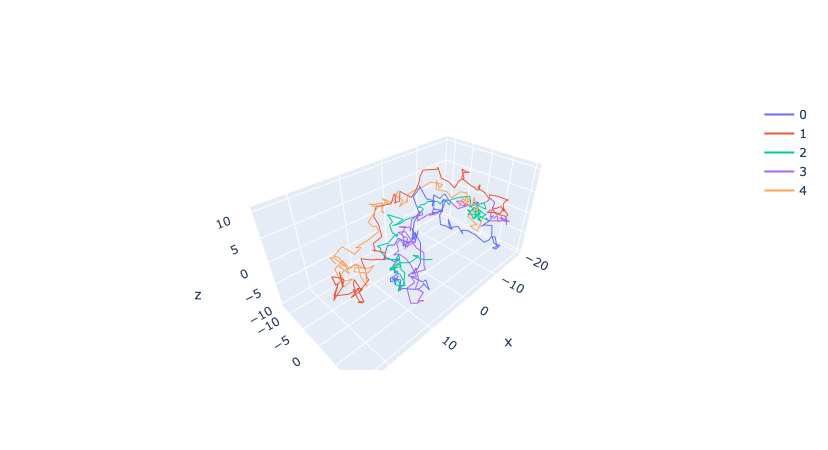

In [72]:
plotter(xs_aligned, style='-')

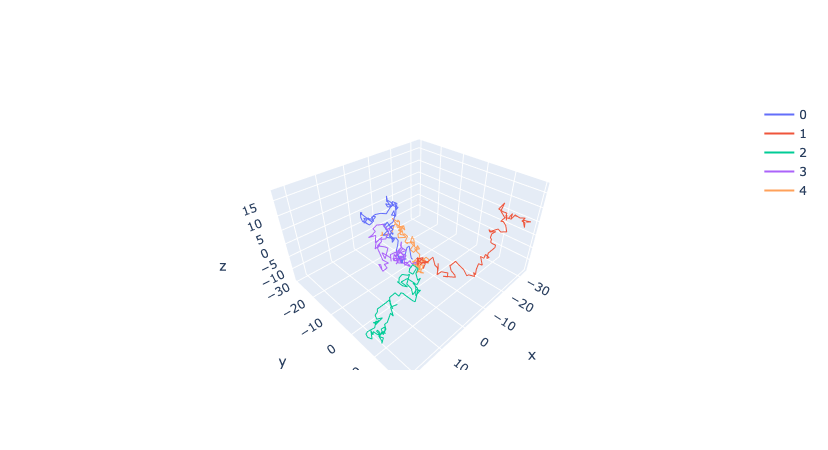

In [73]:
plotter(xs, style='-')

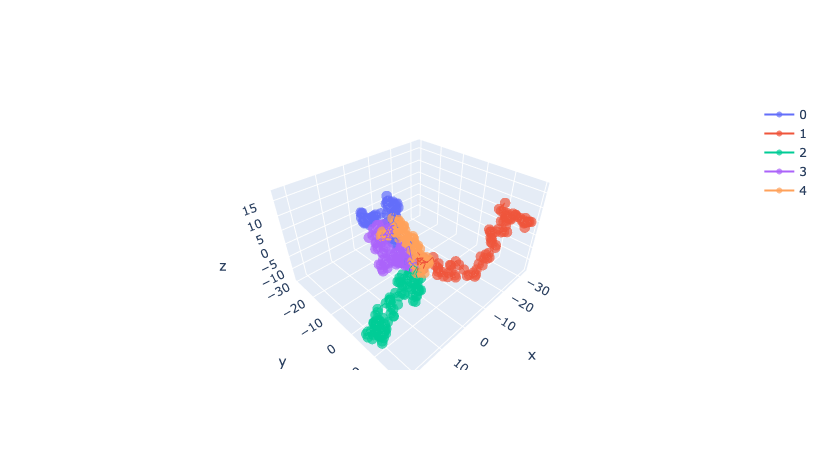

In [75]:
plotter(xs, style='-o')

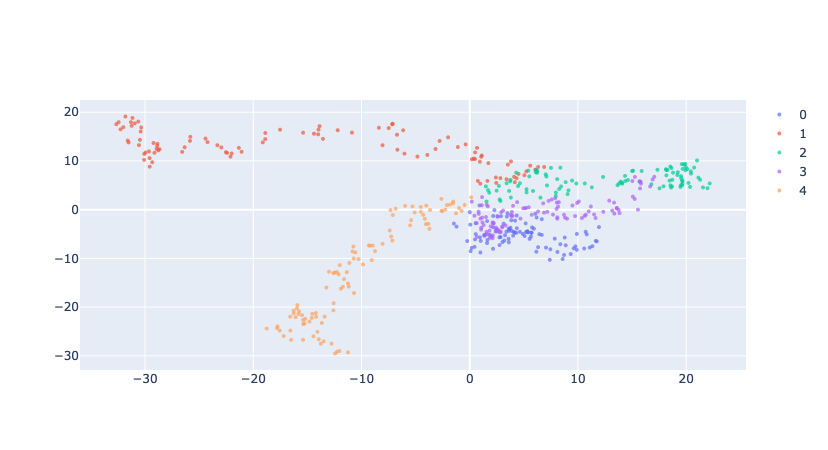

In [76]:
plotter(xs, style='.', reduce_kwargs={'ndims': 2})

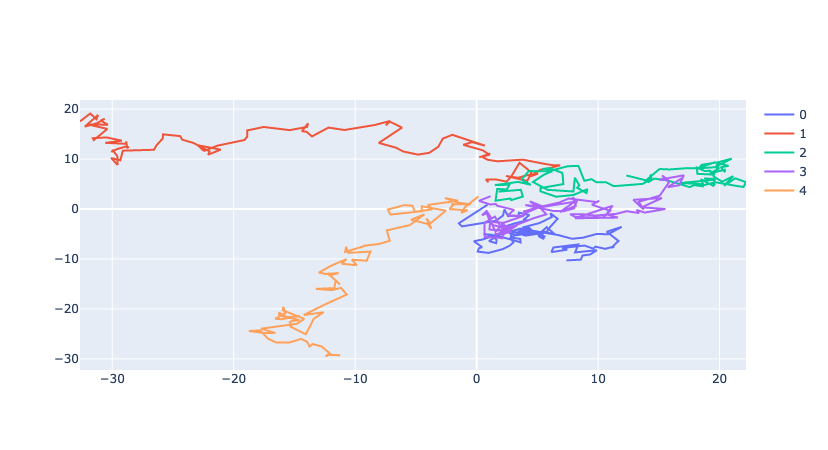

In [77]:
plotter(xs, style='-', reduce_kwargs={'ndims': 2})

In [78]:
sotus_corpus = get_corpus('sotus')

In [79]:
vec_sotus = format_data(sotus_corpus)

In [80]:
vectorized = format_data([sotus_corpus, ['this is a test', 'this is another test', 'raining cats and dogs', 'how much wood could a woodchuck chuck if a woodchuck could chuck wood?']]) #need to change format data to change a list of strings into a single matrix; a list of lists is a lists of matrices

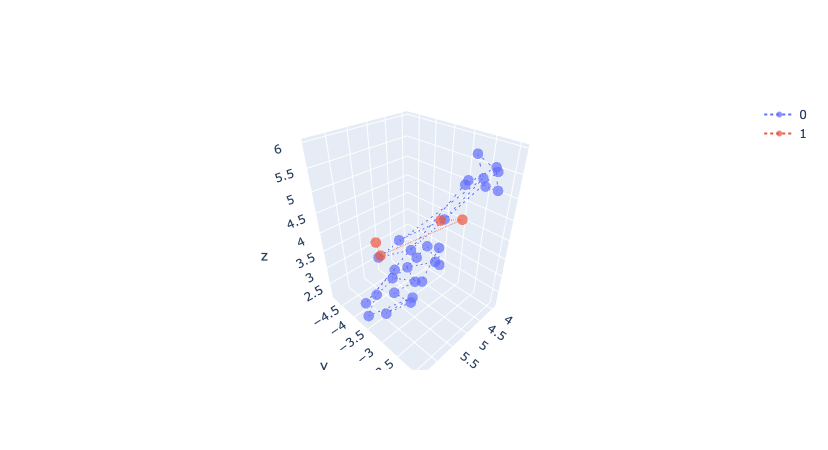

In [81]:
plotter(vectorized, 'o:', reduce_kwargs={'algorithm': 'UMAP'})

In [82]:
text = [sotus_corpus, ['this is a test', 'this is another test', 'raining cats and dogs', 'how much wood could a woodchuck chuck if a woodchuck could chuck wood?']]

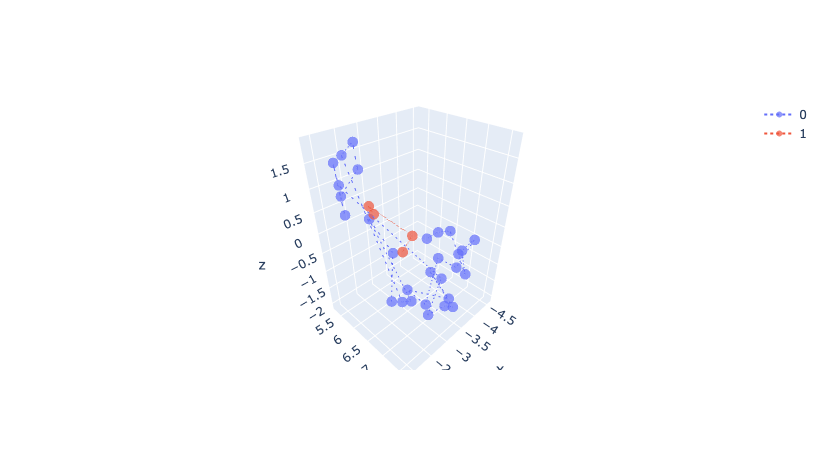

In [83]:
plotter(text, 'o:', reduce_kwargs={'algorithm': 'UMAP'}, text_kwargs={'model': 'LatentDirichletAllocation'})




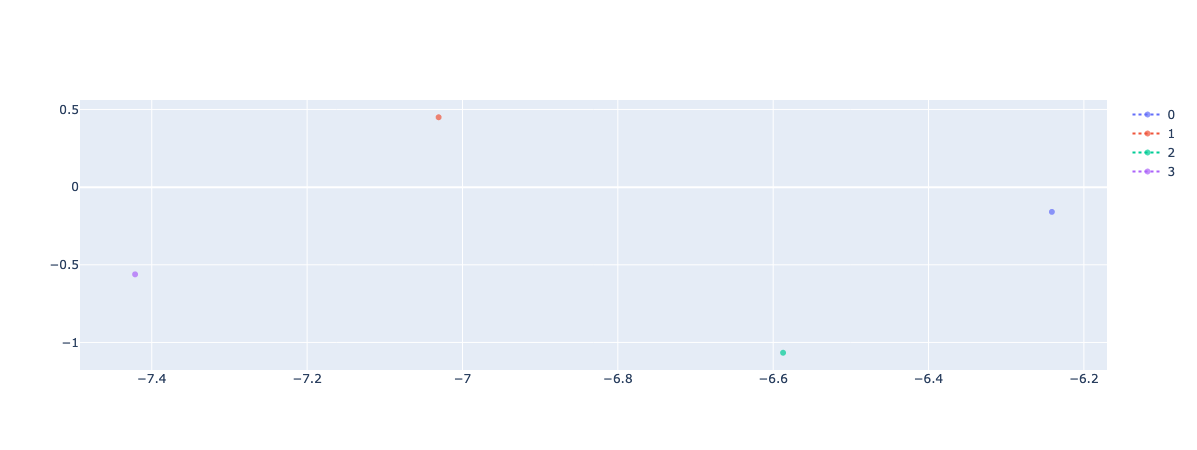

In [84]:
plotter(['cats are the greatest animal', 'apples bananas pears plums', 'this is a test', 'hello how are you?'], 'o:', reduce_kwargs={'ndims': 2, 'algorithm': 'UMAP'}, text_kwargs={'model': 'NMF', 'corpus': 'nips'})



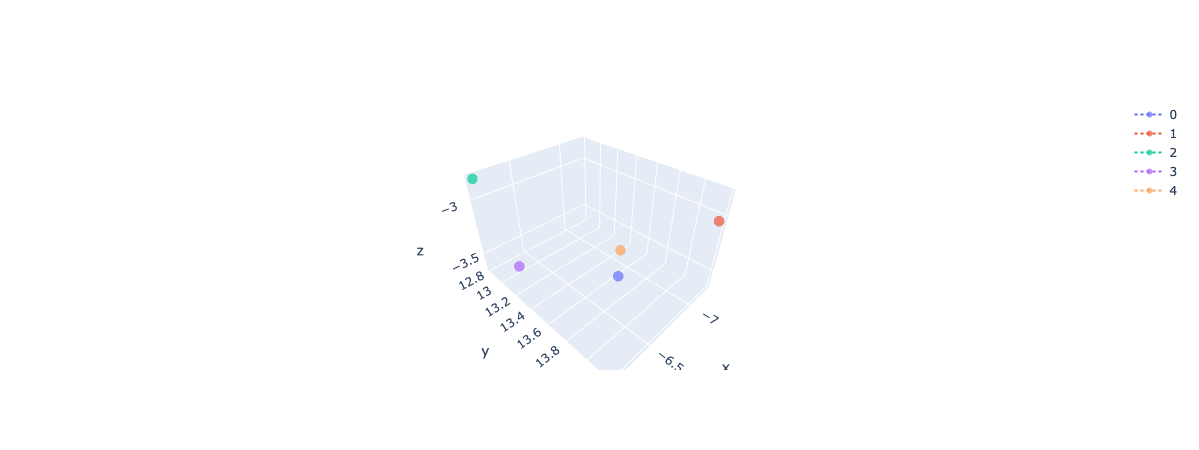

In [85]:
plotter(['cats are the greatest animal', 'apples bananas pears plums', 'this is a test', 'hello world', 'happy birthday to you'], 'o:', reduce_kwargs={'ndims': 3, 'algorithm': 'UMAP'}, text_kwargs={'model': 'NMF', 'corpus': 'nips'})



In [86]:
text2 = ['cats are the greatest animal', 'apples bananas pears plums', 'this is a test', 'happy birthday']

In [87]:
words = ['duck', 'goose', 'hen', 'origami', 'kitten', 'horse', 'paper', 'book', 'paint', 'toy', 'car', 'truck']

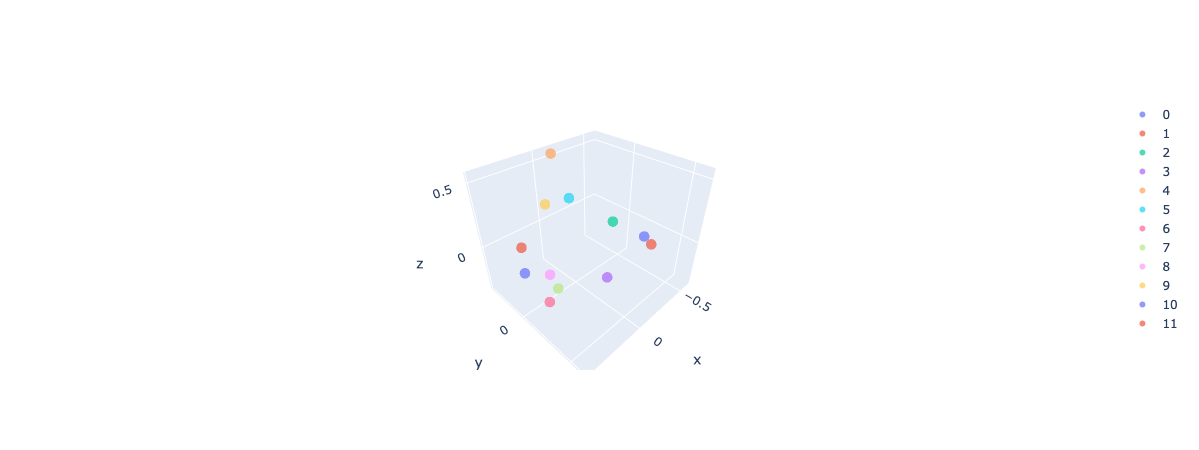

In [88]:
plotter(words, 'o')

In [89]:
vec_words = format_data(words)

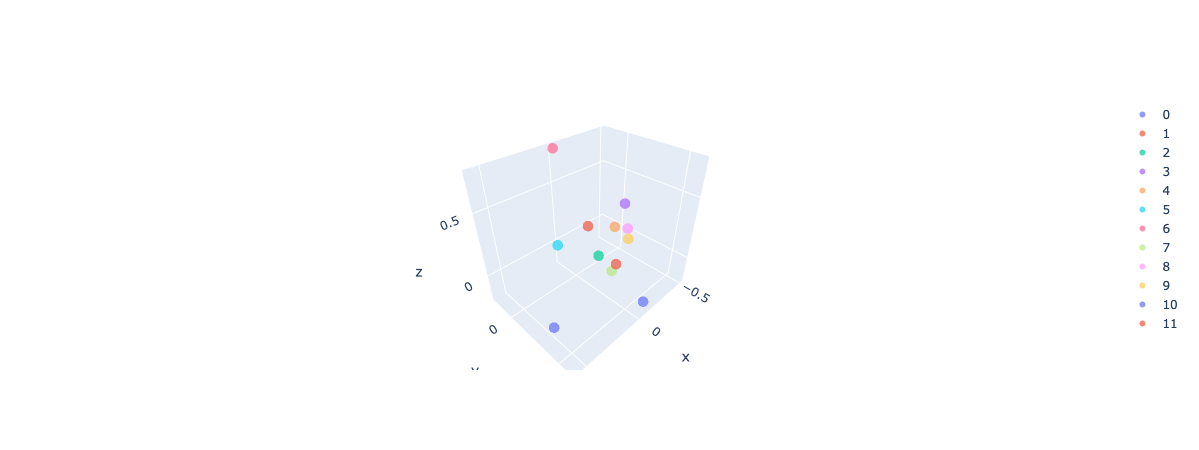

In [90]:
plotter(vec_words, 'o', reduce_kwargs={'algorithm': 'SpectralEmbedding', 'ndims': 3})

In [91]:
vec2 = format_data(text2, text_kwargs={'model': 'LatentDirichletAllocation', 'corpus': 'nips'})

In [92]:
reduce(format_data(vec2), ndims=3, stack=True)

,,0,1,2
0,0,0.596817,0.146442,-0.039561
1,0,-0.131025,-0.374838,-0.310693
2,0,-0.099376,-0.197812,0.416569
3,0,-0.366417,0.426208,-0.066315


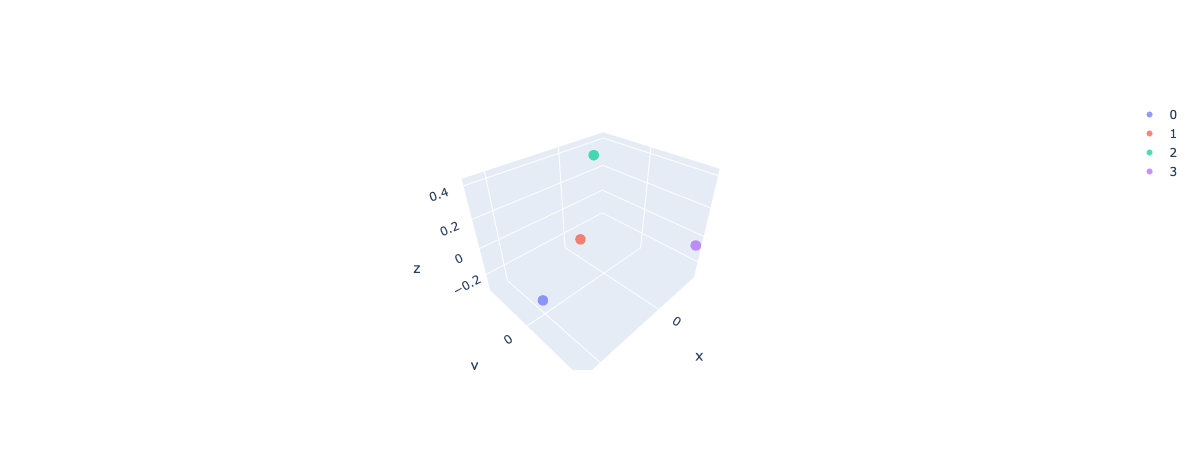

In [93]:
#note: doesn't work without specifying a marker-based line style.  should it?
plotter(vec2, 'o', reduce_kwargs={'ndims': 3})

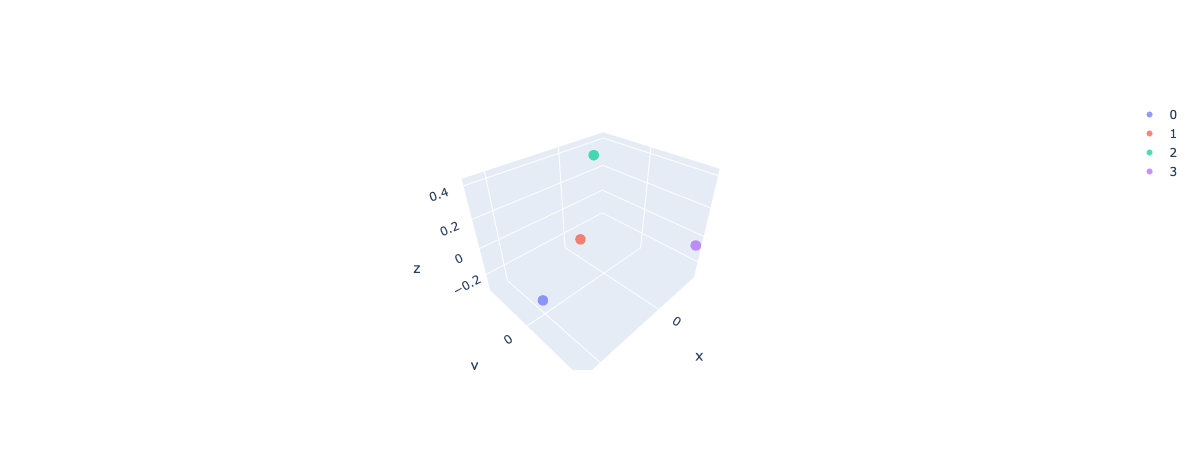

In [94]:
#FIXME: this works, but should be the same as the previous cell
plotter(reduce(vec2, ndims=3), 'o')